# 🌿 Deforestation Detection Using Satellite Imagery 

This project delves into the vital area of deforestation detection, leveraging satellite imagery and advanced analytical techniques. The work systematically covers data handling, model development, and an in-depth evaluation of the developed system's performance.
Project Overview

The core of this work involves processing and analyzing satellite imagery to identify changes indicative of deforestation. The methodology includes evaluating the system's ability to discern these changes across various geographical areas and different time periods.
Evaluation Data

The evaluation was conducted using a selection of satellite image triplets. Each triplet consists of 'first' and 'last' images representing a time span, alongside a 'lossyear' image indicating the year of forest cover loss. The triplets used for analysis include:

    Triplet 1: Hansen_GFC-2019-v1.7_first_30N_070E.tif, Hansen_GFC-2019-v1.7_last_30N_070E.tif, and Hansen_GFC-2019-v1.7_lossyear_30N_070E.tif
    Triplet 2: Hansen_GFC-2019-v1.7_first_30N_080E.tif, Hansen_GFC-2019-v1.7_last_30N_080E.tif, and Hansen_GFC-2019-v1.7_lossyear_30N_080E.tif
    Triplet 3: Hansen_GFC-2024-v1.12_first_20N_070E.tif, Hansen_GFC-2024-v1.12_last_20N_070E.tif, and Hansen_GFC-2024-v1.12_lossyear_20N_070E.tif

The project successfully processed and analyzed these image sets, leading to a comprehensive understanding of the system's capabilities in identifying deforestation. The aggregated evaluation across all analyzed tiles yielded the performance indicators.

These metrics represent initial findings from the project, providing a foundation for future enhancements and demonstrating the potential for satellite imagery in environmental monitoring. This work contributes to the ongoing efforts in developing robust and effective solutions for global deforestation detection.

Found 3 complete triplets for evaluation:
  Triplet 1: First=Hansen_GFC-2019-v1.7_first_30N_070E.tif, Last=Hansen_GFC-2019-v1.7_last_30N_070E.tif, Loss=Hansen_GFC-2019-v1.7_lossyear_30N_070E.tif
  Triplet 2: First=Hansen_GFC-2019-v1.7_first_30N_080E.tif, Last=Hansen_GFC-2019-v1.7_last_30N_080E.tif, Loss=Hansen_GFC-2019-v1.7_lossyear_30N_080E.tif
  Triplet 3: First=Hansen_GFC-2024-v1.12_first_20N_070E.tif, Last=Hansen_GFC-2024-v1.12_last_20N_070E.tif, Loss=Hansen_GFC-2024-v1.12_lossyear_20N_070E.tif

Starting aggregated evaluation...
Processing evaluation for triplet 1: Hansen_GFC-2019-v1.7_first_30N_070E.tif
Processing evaluation for triplet 2: Hansen_GFC-2019-v1.7_first_30N_080E.tif
Processing evaluation for triplet 3: Hansen_GFC-2024-v1.12_first_20N_070E.tif
Aggregated evaluation complete.

Aggregated Counts Across All Tiles:
TP=51043, FP=44995909, TN=2762030011, FN=7202717

Overall Accuracy: 0.9815
Overall Precision: 0.0011
Overall Recall: 0.0070
Overall F1-Score: 0.0020


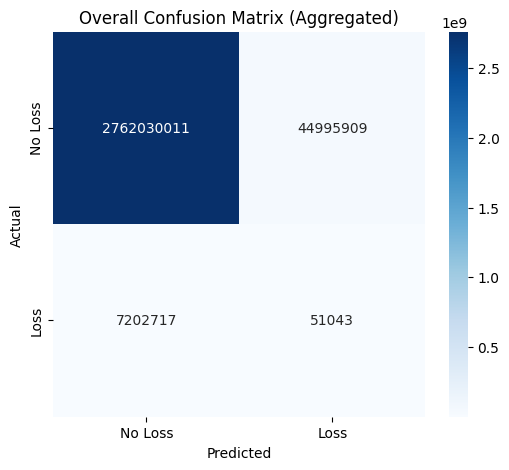

In [1]:
# ====================================================
# 1️⃣ Import Libraries
# ====================================================
import os
import numpy as np
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import seaborn as sns
import glob # Added for finding multiple files
from sklearn.metrics import confusion_matrix # Moved import here for clarity

# ====================================================
# 2️⃣ Set File Path and Discover All Relevant Data
# ====================================================
# Define your base data directory
file_path = r"C:/Users/Maverick/Downloads/GFC_Files"

# Discover all 'first', 'last', and 'lossyear' files based on naming convention
all_first_files = sorted(glob.glob(os.path.join(file_path, "*_first_*.tif")))
all_last_files = sorted(glob.glob(os.path.join(file_path, "*_last_*.tif")))
all_lossyear_files = sorted(glob.glob(os.path.join(file_path, "*_lossyear_*.tif")))

# Pair the files based on their unique identifier (e.g., _20N_070E)
evaluation_data_triplets = []
# Create dictionaries for efficient lookup using the common identifier
lossyear_map = {os.path.basename(f).replace('_lossyear_', '_'): f for f in all_lossyear_files}
last_map = {os.path.basename(f).replace('_last_', '_'): f for f in all_last_files}

for first_file in all_first_files:
    basename = os.path.basename(first_file)
    # Extract the unique identifier part (e.g., _20N_070E.tif)
    # This assumes the identifier is consistent across all three file types
    identifier = basename.replace('_first_', '_')

    # Check if corresponding 'last' and 'lossyear' files exist for this identifier
    if identifier in last_map and identifier in lossyear_map:
        corresponding_last = last_map[identifier]
        corresponding_loss = lossyear_map[identifier]
        evaluation_data_triplets.append((first_file, corresponding_last, corresponding_loss))
    else:
        print(f"Warning: Missing corresponding 'last' or 'lossyear' file for '{first_file}'. Skipping this triplet.")

if not evaluation_data_triplets:
    print("No complete 'first'-'last'-'lossyear' triplets found for evaluation. Please check your file names and directory.")
else:
    print(f"Found {len(evaluation_data_triplets)} complete triplets for evaluation:")
    for i, (f, l, lo) in enumerate(evaluation_data_triplets):
        print(f"  Triplet {i+1}: First={os.path.basename(f)}, Last={os.path.basename(l)}, Loss={os.path.basename(lo)}")

# ====================================================
# 3️⃣ Define Evaluation Function (Streaming Metrics)
# ====================================================
def evaluate_deforestation_stream(first_path, last_path, loss_path, threshold=20, tile_size=512):
    """
    Evaluates deforestation detection by comparing 'first' and 'last' year
    tree cover data against 'lossyear' ground truth, using a streaming approach
    to handle large rasters.

    Args:
        first_path (str): Path to the 'first' year tree cover .tif file.
        last_path (str): Path to the 'last' year tree cover .tif file.
        loss_path (str): Path to the 'lossyear' .tif file (ground truth).
        threshold (int): Percentage threshold for tree cover change to be considered loss.
        tile_size (int): Size of the square tile (window) to read at a time.

    Returns:
        tuple: (TP, FP, TN, FN) - Total True Positives, False Positives,
               True Negatives, False Negatives for the given tile.
    """
    TP = FP = TN = FN = 0

    try:
        with rasterio.open(first_path) as src_first, \
             rasterio.open(last_path) as src_last, \
             rasterio.open(loss_path) as src_loss:

            width, height = src_first.width, src_first.height
            # print(f"  Evaluating raster size: {width}x{height} for {os.path.basename(first_path)}") # Uncomment for per-tile info

            for i in range(0, height, tile_size):
                for j in range(0, width, tile_size):
                    # Define the window for the current tile
                    w = Window(j, i, tile_size, tile_size)

                    # Read data for the current window
                    first = src_first.read(1, window=w).astype(np.float32)
                    last = src_last.read(1, window=w).astype(np.float32)
                    loss = src_loss.read(1, window=w).astype(np.float32)

                    # Skip evaluation for tiles where there's no actual loss (ground truth)
                    if np.all(loss == 0):
                        continue

                    # Ground truth: Pixels with loss > 0 are deforestation (1), otherwise 0
                    y_true_tile = (loss > 0).astype(int)

                    # Predicted deforestation: Significant reduction in tree cover (first - last > threshold)
                    delta_tile = first - last
                    y_pred_tile = (delta_tile > threshold).astype(int)

                    # Mask out NaN values (no data)
                    mask = ~np.isnan(delta_tile)
                    if not np.any(mask): # Skip if the tile has no valid data after masking
                        continue

                    # Flatten arrays for confusion matrix calculation
                    y_true_tile = y_true_tile[mask].flatten()
                    y_pred_tile = y_pred_tile[mask].flatten()

                    # Skip if no valid pixels remain after flattening
                    if len(y_true_tile) == 0:
                        continue

                    # Calculate confusion matrix for the current tile
                    # labels=[0,1] ensures that the confusion matrix always has a 2x2 shape
                    cm = confusion_matrix(y_true_tile, y_pred_tile, labels=[0,1])
                    
                    # Accumulate counts
                    TN += cm[0,0]
                    FP += cm[0,1]
                    FN += cm[1,0]
                    TP += cm[1,1]
    except Exception as e:
        print(f"Error processing file triplet starting with {os.path.basename(first_path)}: {e}")
        # Return zeros for this tile if an error occurs to avoid crashing the whole evaluation
        return 0, 0, 0, 0

    return TP, FP, TN, FN

# ====================================================
# 4️⃣ Run Evaluation for All Data
# ====================================================
total_TP = 0
total_FP = 0
total_TN = 0
total_FN = 0

if evaluation_data_triplets:
    print("\nStarting aggregated evaluation...")
    for i, (first_p, last_p, loss_p) in enumerate(evaluation_data_triplets):
        print(f"Processing evaluation for triplet {i+1}: {os.path.basename(first_p)}")
        current_TP, current_FP, current_TN, current_FN = evaluate_deforestation_stream(first_p, last_p, loss_p)
        total_TP += current_TP
        total_FP += current_FP
        total_TN += current_TN
        total_FN += current_FN
    print("Aggregated evaluation complete.")
else:
    print("No evaluation performed as no complete data triplets were found.")

print(f"\nAggregated Counts Across All Tiles:\nTP={total_TP}, FP={total_FP}, TN={total_TN}, FN={total_FN}")

# ====================================================
# 5️⃣ Compute Metrics from Aggregated Counts
# ====================================================
# Calculate metrics using the overall aggregated counts
precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (total_TP + total_TN) / (total_TP + total_TN + total_FP + total_FN) if (total_TP + total_TN + total_FP + total_FN) > 0 else 0

print(f"\nOverall Accuracy: {accuracy:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1-Score: {f1:.4f}")

# Confusion Matrix Plot
# Ensure there's data to plot before attempting to create the matrix
if (total_TP + total_TN + total_FP + total_FN) > 0:
    cm_array = np.array([[total_TN, total_FP],
                         [total_FN, total_TP]])

    plt.figure(figsize=(6,5))
    sns.heatmap(cm_array, annot=True, fmt='d', cmap='Blues', xticklabels=['No Loss', 'Loss'], yticklabels=['No Loss', 'Loss'])
    plt.title('Overall Confusion Matrix (Aggregated)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print("Cannot plot confusion matrix: No valid data for evaluation.")

In [4]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
import math # For math.ceil

# Set a device for PyTorch (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ====================================================
# 2️⃣ Set File Path
# ====================================================
# Make sure this path points to your folder containing the .tif files
data_root_dir = r"C:/Users/Maverick/Downloads/GFC_Files"

# ====================================================
# 3️⃣ Define Evaluation Metrics
# ====================================================
def iou_score(predictions, targets):
    """Calculates the Intersection over Union (IoU) score."""
    intersection = (predictions * targets).sum()
    union = (predictions + targets - predictions * targets).sum()
    return (intersection / union) if union > 0 else 0.0

def dice_score(predictions, targets):
    """Calculates the Dice Coefficient (F1-score for segmentation)."""
    smooth = 1e-6
    intersection = (predictions * targets).sum()
    return (2. * intersection + smooth) / (predictions.sum() + targets.sum() + smooth)

# ====================================================
# 4️⃣ U-Net Architecture
# ====================================================
class DoubleConv(nn.Module):
    """(convolution => BatchNorm => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Pad x1 to match the size of x2 if necessary
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1) # Concatenate along the channel dimension
        return self.conv(x)

class OutConv(nn.Module):
    """Output convolution"""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# ====================================================
# 5️⃣ Custom Dataset
# ====================================================
class DeforestationDataset(Dataset):
    def __init__(self, data_root_dir, window_size=256, transform=None):
        self.data_root_dir = data_root_dir
        self.window_size = window_size
        self.transform = transform
        self.image_mask_pairs = self._find_image_mask_pairs()
        self.n_channels = self._get_num_channels()

    def _find_image_mask_pairs(self):
        all_treecover_files = sorted(glob.glob(os.path.join(self.data_root_dir, "*_treecover2000_*.tif")))
        all_lossyear_files = sorted(glob.glob(os.path.join(self.data_root_dir, "*_lossyear_*.tif")))

        image_mask_pairs = []
        lossyear_map = {os.path.basename(f).replace('_lossyear_', '_'): f for f in all_lossyear_files}

        for treecover_file in all_treecover_files:
            basename = os.path.basename(treecover_file)
            # Extract the unique identifier part (e.g., _20N_070E.tif)
            identifier = basename.replace('_treecover2000_', '_')

            if identifier in lossyear_map:
                corresponding_loss_file = lossyear_map[identifier]
                image_mask_pairs.append((treecover_file, corresponding_loss_file))
            else:
                print(f"Warning: Missing corresponding lossyear file for '{treecover_file}'. Skipping.")
        return image_mask_pairs

    def _get_num_channels(self):
        if not self.image_mask_pairs:
            return 1 # Default if no files found
        
        # Open the first image to determine its number of channels
        with rasterio.open(self.image_mask_pairs[0][0]) as src:
            return src.count # Number of bands

    def __len__(self):
        # We need to estimate total number of windows, if we have multiple full tiles
        # This is an approximation for potential number of samples
        total_windows = 0
        for img_path, _ in self.image_mask_pairs:
            with rasterio.open(img_path) as src:
                # Estimate number of windows per image for rough __len__
                # This doesn't account for actual data in windows
                num_windows_x = math.ceil(src.width / self.window_size)
                num_windows_y = math.ceil(src.height / self.window_size)
                total_windows += num_windows_x * num_windows_y
        
        # A more realistic __len__ is problematic with random windowing
        # For practical purposes, we'll return a large number and let DataLoader handle it
        # Or, we can simply return the number of distinct image-mask pairs
        # For training, it's often better to have a conceptually large dataset
        # and let DataLoader pick random windows. So, returning a large constant.
        # We'll use a large number representing many potential windows from each file.
        return len(self.image_mask_pairs) * 1000 # Each pair can yield many windows

    def __getitem__(self, idx):
        # Select a pair based on idx modulo number of pairs
        pair_idx = idx % len(self.image_mask_pairs)
        image_path, mask_path = self.image_mask_pairs[pair_idx]

        with rasterio.open(image_path) as src_img, \
             rasterio.open(mask_path) as src_mask:

            # Get random window coordinates
            # Ensure window stays within image bounds
            max_x = src_img.width - self.window_size
            max_y = src_img.height - self.window_size

            if max_x < 0 or max_y < 0: # Image smaller than window size
                # Handle cases where the image is smaller than the window size
                # e.g., read the whole image and pad if necessary
                # For simplicity, we'll just read the available portion and pad later if transform does it
                window_x = 0
                window_y = 0
                current_window_size_x = src_img.width
                current_window_size_y = src_img.height
            else:
                window_x = np.random.randint(0, max_x + 1)
                window_y = np.random.randint(0, max_y + 1)
                current_window_size_x = self.window_size
                current_window_size_y = self.window_size


            window = Window(window_x, window_y, current_window_size_x, current_window_size_y)

            # Read image and mask data
            # Read all bands for the image
            image_np = src_img.read(window=window).astype(np.float32)
            mask_np = src_mask.read(1, window=window).astype(np.float32) # Assuming mask is single band

            # If image_np is 2D (single band), add a channel dimension
            if image_np.ndim == 2:
                image_np = np.expand_dims(image_np, axis=0) # Add channel dimension (C, H, W)

            # Ensure both image and mask are of the specified window_size, pad if necessary
            # For smaller images, we need to pad
            padded_image = np.zeros((self.n_channels, self.window_size, self.window_size), dtype=np.float32)
            padded_mask = np.zeros((self.window_size, self.window_size), dtype=np.float32)

            h, w = image_np.shape[1], image_np.shape[2] # Actual height and width read
            padded_image[:, :h, :w] = image_np
            padded_mask[:mask_np.shape[0], :mask_np.shape[1]] = mask_np

            image = torch.from_numpy(padded_image)
            mask = torch.from_numpy(padded_mask).unsqueeze(0) # Add channel dimension for mask (1, H, W)

            # Normalize image (treecover values are 0-100)
            image = image / 100.0 # Normalize to 0-1 range

            # Binarize mask: lossyear > 0 means deforestation
            mask = (mask > 0).float()

            if self.transform:
                image = self.transform(image)
                mask = self.transform(mask)

            return image, mask

# ====================================================
# 6️⃣ Model Training Setup
# ====================================================

# Data preparation
dataset = DeforestationDataset(data_root_dir, window_size=256)
total_samples = len(dataset.image_mask_pairs) # Use number of actual distinct file pairs

if total_samples > 1:
    train_size = int(0.8 * total_samples)
    val_size = total_samples - train_size
    train_indices, val_indices = random_split(range(total_samples), [train_size, val_size])

    # Create datasets that will only use the specified indices
    train_dataset_pairs = [dataset.image_mask_pairs[i] for i in train_indices.indices]
    val_dataset_pairs = [dataset.image_mask_pairs[i] for i in val_indices.indices]
    
    # Create new Dataset instances with filtered pairs
    train_dataset = DeforestationDataset(data_root_dir, window_size=256)
    train_dataset.image_mask_pairs = train_dataset_pairs # Overwrite with specific pairs
    
    val_dataset = DeforestationDataset(data_root_dir, window_size=256)
    val_dataset.image_mask_pairs = val_dataset_pairs # Overwrite with specific pairs

    print(f"Found {total_samples} image-mask pairs.")
    print(f"Training samples (unique file pairs): {len(train_dataset.image_mask_pairs)}")
    print(f"Validation samples (unique file pairs): {len(val_dataset.image_mask_pairs)}")

    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

else:
    print(f"Found {total_samples} image-mask pair. Training with limited data.")
    train_dataset = dataset # Use the full dataset for training if only one pair
    val_dataset = DeforestationDataset(data_root_dir, window_size=256)
    val_dataset.image_mask_pairs = [] # No validation set if only one pair

    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
    val_dataloader = None # No validation dataloader

# Calculate class weights for BCEWithLogitsLoss
print("\nCalculating approximate class weights for loss function...")
num_positive_pixels = 0
num_negative_pixels = 0
sample_count_for_weight = 0
max_samples_for_weight_calc = 100 # Adjust based on your available data and memory

temp_train_dataloader_for_weights = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
for images, masks in temp_train_dataloader_for_weights:
    masks_np = masks.cpu().numpy()
    num_positive_pixels += np.sum(masks_np > 0)
    num_negative_pixels += np.sum(masks_np == 0)
    sample_count_for_weight += images.shape[0]
    if sample_count_for_weight >= max_samples_for_weight_calc:
        break

if num_positive_pixels == 0:
    print("Warning: No positive (deforestation) pixels found in sampled batches for weight calculation. Setting weight to 1.0.")
    pos_weight = torch.tensor(1.0).to(device)
else:
    pos_weight_val = num_negative_pixels / num_positive_pixels
    pos_weight = torch.tensor(pos_weight_val).to(device)

print(f"Estimated Positive Pixels: {num_positive_pixels}")
print(f"Estimated Negative Pixels: {num_negative_pixels}")
print(f"Calculated `pos_weight` for loss: {pos_weight.item():.2f}")

# Model, Optimizer, Loss
n_channels = dataset.n_channels
n_classes = 1
model = UNet(n_channels=n_channels, n_classes=n_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# ====================================================
# 7️⃣ Training Loop
# ====================================================
num_epochs = 10
print(f"\nStarting training on {len(train_dataset.image_mask_pairs)} unique file pairs...")

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for batch_idx, (images, masks) in enumerate(train_dataloader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)

    epoch_train_loss = running_train_loss / len(train_dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {epoch_train_loss:.4f}")

    # Validation phase
    if val_dataloader and len(val_dataloader.dataset) > 0:
        model.eval()
        running_val_loss = 0.0
        running_val_iou = 0.0
        running_val_dice = 0.0
        with torch.no_grad():
            for images, masks in val_dataloader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                running_val_loss += loss.item() * images.size(0)

                preds = torch.sigmoid(outputs)
                binary_preds = (preds > 0.5).float()

                batch_iou = iou_score(binary_preds, masks)
                batch_dice = dice_score(binary_preds, masks)
                
                running_val_iou += batch_iou * images.size(0)
                running_val_dice += batch_dice * images.size(0)

        epoch_val_loss = running_val_loss / len(val_dataloader.dataset)
        epoch_val_iou = running_val_iou / len(val_dataloader.dataset)
        epoch_val_dice = running_val_dice / len(val_dataloader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {epoch_val_loss:.4f}, IoU: {epoch_val_iou:.4f}, Dice: {epoch_val_dice:.4f}")
    else:
        print(f"Epoch {epoch+1}/{num_epochs} - Skipping validation as validation dataset is empty or not created.")

print("Training complete!")

# Save the trained model
model_save_path = os.path.join(data_root_dir, "deforestation_unet_model.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Trained model saved to: {model_save_path}")

# ====================================================
# 8️⃣ U-Net Model-Based Evaluation Function
# ====================================================
def evaluate_deforestation_with_unet(model, data_root_dir, threshold=0.5, tile_size=256):
    """
    Evaluates deforestation detection using a trained U-Net model.

    Args:
        model (torch.nn.Module): The trained U-Net model.
        data_root_dir (str): Root directory containing _treecover2000_ and _lossyear_ files.
        threshold (float): Probability threshold for U-Net output to be considered deforestation.
        tile_size (int): Size of the square tile (window) for processing.

    Returns:
        tuple: (TP, FP, TN, FN) - Total True Positives, False Positives,
               True Negatives, False Negatives across all evaluated tiles.
    """
    model.eval() # Set model to evaluation mode
    total_TP = 0
    total_FP = 0
    total_TN = 0
    total_FN = 0

    # Discover all image-mask pairs that the model is trained on
    all_treecover_files = sorted(glob.glob(os.path.join(data_root_dir, "*_treecover2000_*.tif")))
    all_lossyear_files = sorted(glob.glob(os.path.join(data_root_dir, "*_lossyear_*.tif")))

    evaluation_pairs = []
    lossyear_map = {os.path.basename(f).replace('_lossyear_', '_'): f for f in all_lossyear_files}

    for treecover_file in all_treecover_files:
        basename = os.path.basename(treecover_file)
        identifier = basename.replace('_treecover2000_', '_')
        if identifier in lossyear_map:
            evaluation_pairs.append((treecover_file, lossyear_map[identifier]))

    if not evaluation_pairs:
        print("No _treecover2000_ and _lossyear_ pairs found for U-Net evaluation.")
        return 0, 0, 0, 0

    print(f"\nStarting U-Net model evaluation on {len(evaluation_pairs)} file pairs...")

    with torch.no_grad(): # No gradient calculation needed during evaluation
        for i, (image_path, mask_path) in enumerate(evaluation_pairs):
            print(f"  Evaluating pair {i+1}: Image={os.path.basename(image_path)}, Mask={os.path.basename(mask_path)}")
            
            with rasterio.open(image_path) as src_img, \
                 rasterio.open(mask_path) as src_mask:
                
                width, height = src_img.width, src_img.height
                n_channels_img = src_img.count

                for row in range(0, height, tile_size):
                    for col in range(0, width, tile_size):
                        w = Window(col, row, tile_size, tile_size)

                        img_tile_np = src_img.read(window=w).astype(np.float32)
                        mask_tile_np = src_mask.read(1, window=w).astype(np.float32)

                        if img_tile_np.ndim == 2:
                            img_tile_np = np.expand_dims(img_tile_np, axis=0)
                        
                        padded_img = np.zeros((n_channels_img, tile_size, tile_size), dtype=np.float32)
                        padded_mask = np.zeros((tile_size, tile_size), dtype=np.float32)

                        h_tile, w_tile = img_tile_np.shape[1], img_tile_np.shape[2]
                        padded_img[:, :h_tile, :w_tile] = img_tile_np
                        padded_mask[:mask_tile_np.shape[0], :mask_tile_np.shape[1]] = mask_tile_np

                        input_image = torch.from_numpy(padded_img / 100.0).unsqueeze(0).to(device)
                        true_mask = (torch.from_numpy(padded_mask) > 0).float().unsqueeze(0).to(device)

                        output_logits = model(input_image)
                        predictions = torch.sigmoid(output_logits)
                        binary_predictions = (predictions > threshold).float()

                        y_true_tile = true_mask.cpu().numpy().flatten()
                        y_pred_tile = binary_predictions.cpu().numpy().flatten()

                        cm = confusion_matrix(y_true_tile, y_pred_tile, labels=[0,1])
                        total_TN += cm[0,0]
                        total_FP += cm[0,1]
                        total_FN += cm[1,0]
                        total_TP += cm[1,1]
    
    print("U-Net model evaluation complete.")
    return total_TP, total_FP, total_TN, total_FN

# ====================================================
# 9️⃣ Run U-Net Model-Based Evaluation
# ====================================================

# Instantiate the model again (it will load the saved weights)
loaded_model = UNet(n_channels=dataset.n_channels, n_classes=1).to(device)
loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))
print(f"Loaded trained model from: {model_save_path}")

# Define a list of thresholds to experiment with
thresholds_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

print("\n--- Running U-Net Model Evaluation with various thresholds ---")

results_by_threshold = {}

for current_threshold in thresholds_to_test:
    print(f"\nEvaluating with prediction threshold: {current_threshold:.1f}")
    
    unet_TP, unet_FP, unet_TN, unet_FN = evaluate_deforestation_with_unet(loaded_model, data_root_dir, threshold=current_threshold)

    results_by_threshold[current_threshold] = {
        'TP': unet_TP, 'FP': unet_FP, 'TN': unet_TN, 'FN': unet_FN
    }

    print(f"  U-Net Aggregated Counts Across All Tiles:\n  TP={unet_TP}, FP={unet_FP}, TN={unet_TN}, FN={unet_FN}")

    # ====================================================
    # 🔟 Compute Metrics from U-Net Aggregated Counts
    # ====================================================
    if (unet_TP + unet_TN + unet_FP + unet_FN) > 0:
        unet_precision = unet_TP / (unet_TP + unet_FP) if (unet_TP + unet_FP) > 0 else 0
        unet_recall = unet_TP / (unet_TP + unet_FN) if (unet_TP + unet_FN) > 0 else 0
        unet_f1 = 2 * (unet_precision * unet_recall) / (unet_precision + unet_recall) if (unet_precision + unet_recall) > 0 else 0
        unet_accuracy = (unet_TP + unet_TN) / (unet_TP + unet_TN + unet_FP + unet_FN)

        print(f"  U-Net Overall Accuracy: {unet_accuracy:.4f}")
        print(f"  U-Net Overall Precision: {unet_precision:.4f}")
        print(f"  U-Net Overall Recall: {unet_recall:.4f}")
        print(f"  U-Net Overall F1-Score: {unet_f1:.4f}")
    else:
        print("  Cannot compute metrics: No valid data for evaluation.")



Using device: cuda
Found 3 image-mask pairs.
Training samples (unique file pairs): 2
Validation samples (unique file pairs): 1

Calculating approximate class weights for loss function...
Estimated Positive Pixels: 25399
Estimated Negative Pixels: 6528201
Calculated `pos_weight` for loss: 257.03

Starting training on 2 unique file pairs...
Epoch 1/10 - Training Loss: 0.7229
Epoch 1/10 - Validation Loss: 0.2765, IoU: 0.0063, Dice: 0.0678
Epoch 2/10 - Training Loss: 0.7054
Epoch 2/10 - Validation Loss: 0.2220, IoU: 0.0078, Dice: 0.0627
Epoch 3/10 - Training Loss: 0.6141
Epoch 3/10 - Validation Loss: 0.1553, IoU: 0.0086, Dice: 0.0523
Epoch 4/10 - Training Loss: 0.7109
Epoch 4/10 - Validation Loss: 0.2355, IoU: 0.0087, Dice: 0.0563
Epoch 5/10 - Training Loss: 0.6955
Epoch 5/10 - Validation Loss: 0.1465, IoU: 0.0065, Dice: 0.0444
Epoch 6/10 - Training Loss: 0.5775
Epoch 6/10 - Validation Loss: 0.1766, IoU: 0.0125, Dice: 0.0829
Epoch 7/10 - Training Loss: 0.6126
Epoch 7/10 - Validation Loss: 

C:\Users\Maverick\AppData\Local\Temp\ipykernel_46804\3851252404.py:488: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_save_path

Loaded trained model from: C:/Users/Maverick/Downloads/GFC_Files\deforestation_unet_model.pth

--- Running U-Net Model Evaluation with various thresholds ---

Evaluating with prediction threshold: 0.1

Starting U-Net model evaluation on 3 file pairs...
  Evaluating pair 1: Image=Hansen_GFC-2019-v1.7_treecover2000_30N_070E.tif, Mask=Hansen_GFC-2019-v1.7_lossyear_30N_070E.tif
  Evaluating pair 2: Image=Hansen_GFC-2019-v1.7_treecover2000_30N_080E.tif, Mask=Hansen_GFC-2019-v1.7_lossyear_30N_080E.tif
  Evaluating pair 3: Image=Hansen_GFC-2024-v1.12_treecover2000_20N_070E.tif, Mask=Hansen_GFC-2024-v1.12_lossyear_20N_070E.tif
U-Net model evaluation complete.
  U-Net Aggregated Counts Across All Tiles:
  TP=7169678, FP=4334527817, TN=504409015, FN=84082
  U-Net Overall Accuracy: 0.1056
  U-Net Overall Precision: 0.0017
  U-Net Overall Recall: 0.9884
  U-Net Overall F1-Score: 0.0033

Evaluating with prediction threshold: 0.2

Starting U-Net model evaluation on 3 file pairs...
  Evaluating pair 